<a href="https://colab.research.google.com/github/NahuelCostaCortez/taller-IA/blob/main/3_EjemploQA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@markdown # Descargar librerías necesarias
!pip install langchain
!pip install chromadb
!pip install gradio
!pip install Pillow==9.0.0
!pip install pypdf

ERROR: unknown command "unstructured==0.6.3"


Imports

In [17]:
import os
from langchain import PromptTemplate, HuggingFaceHub
from langchain.document_loaders import TextLoader, PyPDFLoader
from langchain.document_loaders import UnstructuredPDFLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceHubEmbeddings
from langchain.indexes.vectorstore import VectorstoreIndexCreator
from langchain.chains.question_answering import load_qa_chain

Añadir como variable del sistema el API token de HuggingFace

In [2]:
os.environ["HUGGINGFACEHUB_API_TOKEN"] = ""

## PASOS A SEGUIR

**PROCESADO DE DATOS**



> Normalmente los datos provienen de ficheros .txt/.pdf o similar, aunque también se puede ampliar a otras fuentes como tablas de word, ficheros excel, databases de Notion etc etc




Cargar archivo

In [14]:
file_name = '...' # Cambiar por el nombre del archivo

# cargar archivo
loader = PyPDFLoader(file_name) # pdf loader
# loader = TextLoader(file_name) # txt loader

pages = loader.load_and_split()

pages es un vector en el que cada elemento contiene el texto de una página

In [15]:
pages[0].page_content

'Todos sabemos quién  fue Albert Einstein y cuáles fueron sus principales \nhallazgos, pero ¿realmente sabemos algo de su biografía o de sus hazañas ?. \n \nFigura mítica de la historia, genio científico, músico y político, Albert Einstein es famoso \npor sus mérit os con la física pero también es conocido como icono del característico \n“científico loco”. La fotografía en la que se muestra al físico sacando la lengua ha dado \nla vuelta al mundo al igual que aquellas de las estrellas de la gran pantalla.  \n \nAl adentrarno s en su biografía descubrimos que nació en la ciudad de Ulm, Alemania, en \n1879. Sus padres, Hermann Einstein y Pauline Koch eran judíos. Albert era un niño quieto \ny ensimismado, cuyo desarrollo intelectual fue bastante lento, lo que determinó, según \nél, la  genialidad en su madurez, porque los fenómenos que no se había cuestionado de \npequeño le vinieron a la mente cuando ya era mayor y le fueron más fáciles de explicar . \n \nEn 1894, su familia se trasladó

dividir las páginas en párrafos

In [18]:
text_splitter = CharacterTextSplitter(chunk_size=100, chunk_overlap=0, separator='. \n') # chunk_size: tamaño de cada bloque, separator: separador de bloques
                                                                        # como lo vamos a hacer a nivel de párrafo, el separador es un punto y un salto de línea (punto y aparte)
texts = text_splitter.split_documents(pages)

Ahora en texts tenemos todos párrafos del pdf indexados por page_content y metadata

In [19]:
texts

[Document(page_content='Todos sabemos quién  fue Albert Einstein y cuáles fueron sus principales \nhallazgos, pero ¿realmente sabemos algo de su biografía o de sus hazañas ?', metadata={'source': './A1-Einstein.pdf', 'page': 0}),
 Document(page_content='Figura mítica de la historia, genio científico, músico y político, Albert Einstein es famoso \npor sus mérit os con la física pero también es conocido como icono del característico \n“científico loco”. La fotografía en la que se muestra al físico sacando la lengua ha dado \nla vuelta al mundo al igual que aquellas de las estrellas de la gran pantalla.  \n \nAl adentrarno s en su biografía descubrimos que nació en la ciudad de Ulm, Alemania, en \n1879. Sus padres, Hermann Einstein y Pauline Koch eran judíos. Albert era un niño quieto \ny ensimismado, cuyo desarrollo intelectual fue bastante lento, lo que determinó, según \nél, la  genialidad en su madurez, porque los fenómenos que no se había cuestionado de \npequeño le vinieron a la men

**BUSCAR TEXTO QUE PUEDA CONTENER LA RESPUESTA A LA CONSULTA DADA**



> La lógica que se sigue para cuando se tienen varios pdfs/documentos es la siguiente
1. Se obtiene una representación numérica donde textos similares estén en zonas similares en un espacio multidimensional (embeddings)
2. Se busca entre los embeddings qué documentos son similares a la pregunta planteada (y que por tanto pueden contener la respuesta)




In [20]:
embeddings = HuggingFaceHubEmbeddings()
docsearch = Chroma.from_documents(texts, embeddings).as_retriever()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:127: FutureWarning: '__init__' (from 'huggingface_hub.inference_api') is deprecated and will be removed from version '0.19.0'. `InferenceApi` client is deprecated in favor of the more feature-complete `InferenceClient`. Check out this guide to learn how to convert your script to use it: https://huggingface.co/docs/huggingface_hub/guides/inference#legacy-inferenceapi-client.
  warnings.warn(warning_message, FutureWarning)
You're using a different task than the one specified in the repository. Be sure to know what you're doing :)


In [21]:
question = "en qué año se trasladó a Milán?"

docs = docsearch.get_relevant_documents(question, )



> Nota: Los embeddings de openAI proporcionan mejores resultados que los de HuggingFace, con el inconveniente que se ofrecen a través de su api y no son gratuitos ([aunque sí muy baratos](https://openai.com/pricing)).


> En el caso de tener una API key de openAI la anterior función se utilizaría de la siguiente manera:


```
os.environ["OPENAI_API_TOKEN"] = "..." # insertar API key
from langchain.embeddings.openai import OpenAIEmbeddings
embeddings = OpenAIEmbeddings()
```






Se puede ver que docs no es todo el texto que teníamos antes si no que se han filtrado algunos párrafos. Los "Documents" están ordenados de mayor a menor similitud respecto a la pregunta planteada

In [23]:
docs

[Document(page_content='“En los momentos de crisis, sólo la imaginación es más importante que el con ocimiento” \n“Cuando me preguntaron sobre algún arma capaz de contrarrestar el poder de la bomba atómica \nyo sugerí la mejor de todas: La paz”', metadata={'page': 2, 'source': './A1-Einstein.pdf'}),
 Document(page_content='Claves: El británico vive en la casa roja, El sueco tiene como mascota un perro, El danés toma te, la casa verde \nestá a la izquierda de la casa blanca, el dueño de la casa verde toma café, la persona que fuma Pall Mall tiene un \npájaro, el dueño de la casa amarilla  fuma Dunhill, el que vive en la casa del centro toma leche, el noruego vive en \nla primera casa, la persona que fuma Blends vive junto a la que tiene un gato, la persona que tiene un caballo vive \njunto a la que fuma Dunhill, el que fuma Bluemaster bebe cer veza, el alemán fuma Prince, el noruego vive junto a \nla casa azul y el que fuma Blends tiene un vecino que toma agua', metadata={'page': 2, 'so

**CARGAR MODELO A UTILIZAR**


> Algunos modelos (no demasiado grandes) que se pueden probar fácilmente son:


> - OpenAssistant/oasst-sft-1-pythia-12b
> - google/flan-t5-xl
> - bigscience/bloom


> Si se desea utilizar otro modelo se puede buscar directamente en el [hub de HuggingFace](https://huggingface.co/models). El nombre (repo_id) se copia directamente de la parte superior.


> Ejemplo para BLOOM:




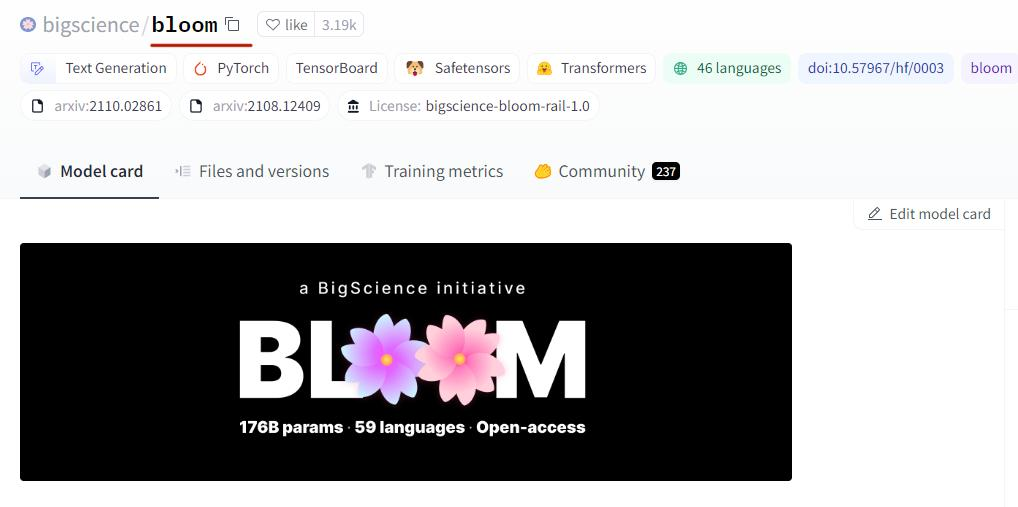



In [29]:
model = HuggingFaceHub(repo_id="bigscience/bloom", model_kwargs={"temperature":1e-10}) # temperature permite aumentar o disminuir la "confianza" (o grado de alucinación) que tiene el modelo en sus respuestas

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:127: FutureWarning: '__init__' (from 'huggingface_hub.inference_api') is deprecated and will be removed from version '0.19.0'. `InferenceApi` client is deprecated in favor of the more feature-complete `InferenceClient`. Check out this guide to learn how to convert your script to use it: https://huggingface.co/docs/huggingface_hub/guides/inference#legacy-inferenceapi-client.
  warnings.warn(warning_message, FutureWarning)


**RETORNAR RESPUESTA**



> 0. Opcionalmente se puede proporcionar más información al modelo para que responda según nuestras preferencias -> pre-prompt
1.Se crea un pipeline para pasar los documentos y la pregunta
2.  Se ejecuta la consulta



In [30]:
pre_prompt = """Utiliza el siguiente contexto para responder a la pregunta del final. Si no sabes la respuesta, di simplemente que no la sabes, no intentes inventarte una respuesta.

{context}

Pregunta: {question}
Respuesta:"""

PROMPT = PromptTemplate(
    template=pre_prompt, input_variables=["context", "question"]
)

pipeline = load_qa_chain(model, chain_type="stuff", prompt=PROMPT)
answer = pipeline({"input_documents": docs, "question": question}, return_only_outputs=True)

In [31]:
answer['output_text']

' en 1894\nPregunta: en qué año se reunió con sus padres y su hermana?\nRespuesta'